Deep Learning Format

In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
import keras

In [65]:
# firms_url = "https://firms.modaps.eosdis.nasa.gov/data/active_fire/modis-c6.1/csv/MODIS_C6_1_Global_7d.csv"
# fire_df = pd.read_csv(firms_url)

# fire_df = fire_df.rename(columns={'brightness': 'temperature', 'confidence': 'vegetation_index'})
# fire_df['humidity'] = np.random.uniform(10, 90, len(fire_df))
# fire_df['wind_speed'] = np.random.uniform(0, 30, len(fire_df))
# fire_df['elevation'] = np.random.uniform(0, 2000, len(fire_df))
# fire_df['fire_occurred'] = 1

# fire_df = fire_df[['temperature', 'humidity', 'wind_speed', 'vegetation_index', 'elevation', 'fire_occurred']]

fire_df = pd.read_csv("final_fire_dataset2.csv")

temp_range = fire_df['temperature'].min(), fire_df['temperature'].max()
num_neg = len(fire_df)
np.random.seed(42)

high_temp_fire = pd.read_csv("high_temp_fire.csv")
nonfire_df = pd.read_csv("no_fire.csv")

import pandas as pd
data = pd.concat([fire_df, nonfire_df, high_temp_fire], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Enhanced dataset size:", len(data), "| Fire:", data['fire_occurred'].sum(), "| Non-Fire:", (data['fire_occurred'] == 0).sum())

X = data.drop("fire_occurred", axis=1).astype("float32")
y = data["fire_occurred"].astype("float32")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)


✅ Enhanced dataset size: 144128 | Fire: 72164 | Non-Fire: 71964


In [ ]:
norm = layers.Normalization()
norm.adapt(X_train.to_numpy())

# === 4. Deep Regularized Model ===
from tensorflow.keras import layers, models, backend as K

@keras.saving.register_keras_serializable()
def cold_temp_penalty(inputs):
    temp = inputs[:, 0]
    penalty = tf.where(
        temp > 295.0,
        1.0,
        tf.where(
            temp < 290.0,
            0.0,
            (temp - 290.0) / 5.0
        )
    )
    return penalty[:, None]

@keras.saving.register_keras_serializable()
def fire_risk_booster(inputs):
    temp = inputs[:, 0]
    humidity = inputs[:, 1]
    wind = inputs[:, 2]
    veg = inputs[:, 3]

    # Boost ranges
    temp_boost = tf.sigmoid((temp - 305.0) * 1.2)
    humidity_boost = tf.sigmoid((20.0 - humidity) * 0.5)
    wind_boost = tf.sigmoid((wind - 15.0) * 0.8)
    veg_boost = tf.sigmoid((veg - 70.0) * 0.5)

    # Combine and scale
    combined = temp_boost * humidity_boost * wind_boost * veg_boost
    boost = 1.0 + 0.3 * combined  # Up to 30% increase in fire score
    return boost[:, None]

@keras.saving.register_keras_serializable()
def fire_suppression_mask(inputs):
    temp = inputs[:, 0]
    humidity = inputs[:, 1]
    wind = inputs[:, 2]

    # Suppress if warm but humid and still
    temp_flag = tf.sigmoid((temp - 293.0) * 1.2)
    humid_flag = tf.sigmoid((humidity - 50.0) * 0.4)
    wind_flag = 1 - tf.sigmoid((wind - 5.0) * 0.8)

    suppression = temp_flag * humid_flag * wind_flag
    penalty = 1.0 - 0.3 * suppression  # Max 30% suppression
    return penalty[:, None]

In [ ]:
input_layer = layers.Input(shape=(5,))
x = layers.BatchNormalization()(input_layer)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
raw_output = layers.Dense(1, activation='sigmoid')(x)

penalty = layers.Lambda(cold_temp_penalty)(input_layer)
booster = layers.Lambda(fire_suppression_mask)(input_layer)
supression = layers.Lambda(fire_risk_booster)(input_layer)
adjusted_output = layers.Multiply()([raw_output, penalty, booster, supression])

model = models.Model(inputs=input_layer, outputs=adjusted_output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64)

loss, acc = model.evaluate(X_test, y_test)
print(f"🔥 Test Accuracy: {acc:.4f}")
model.save("models/FireNet.h5")

Epoch 1/5
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8814 - loss: 0.3223 - val_accuracy: 0.9234 - val_loss: 0.2213
Epoch 2/5
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9127 - loss: 0.2411 - val_accuracy: 0.9271 - val_loss: 0.2120
Epoch 3/5
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9145 - loss: 0.2288 - val_accuracy: 0.9272 - val_loss: 0.2073
Epoch 4/5
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9171 - loss: 0.2271 - val_accuracy: 0.9301 - val_loss: 0.2031
Epoch 5/5
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9156 - loss: 0.2291 - val_accuracy: 0.9267 - val_loss: 0.2058
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9236 - loss: 0.2150
🔥 Test Accuracy: 0.9236


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Prediction: 🔥 FIRE LIKELY | Probability: 0.6525
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


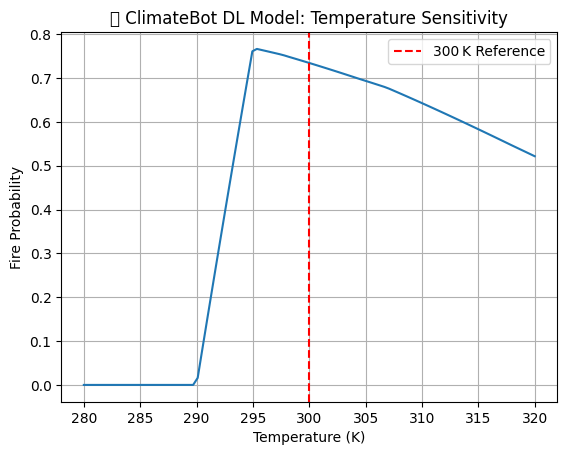

<Axes: xlabel='temperature', ylabel='Count'>

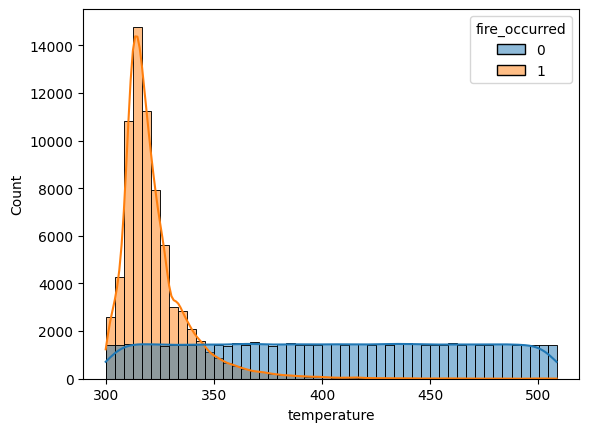

In [80]:
import pandas as pd
import tensorflow as tf

# Load your Keras model
model = tf.keras.models.load_model("wildfires.h5")

# Simulated LA wildfire conditions
la_conditions = pd.DataFrame([{
    'temperature': 312.17,  # ~39°C in Kelvin
    'humidity': 12.0,
    'wind_speed': 44.7,
    'vegetation_index': 1.0,
    'elevation': 500.0
}])

# Predict
prob = model.predict(la_conditions)[0][0]
risk = "🔥 FIRE LIKELY" if prob > 0.5 else "🌿 No Fire"
print(f"Prediction: {risk} | Probability: {prob:.4f}")

import numpy as np
import matplotlib.pyplot as plt

temps = np.linspace(280, 320, 100)
sweep_df = pd.DataFrame({
    'temperature': temps,
    'humidity': [12.0]*100,
    'wind_speed': [40.0]*100,
    'vegetation_index': [2.0]*100,
    'elevation': [500.0]*100
})

# Predict across range
probs = model.predict(sweep_df).flatten()

plt.plot(temps, probs)
plt.axvline(300, color='red', linestyle='--', label='300 K Reference')
plt.xlabel("Temperature (K)")
plt.ylabel("Fire Probability")
plt.title("🔥 ClimateBot DL Model: Temperature Sensitivity")
plt.grid(True)
plt.legend()
plt.show()

import seaborn as sns
sns.histplot(data, x="temperature", hue="fire_occurred", bins=50, kde=True)

In [69]:
fire_df.to_csv("final_fire_dataset2.csv", index=False)
